[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.


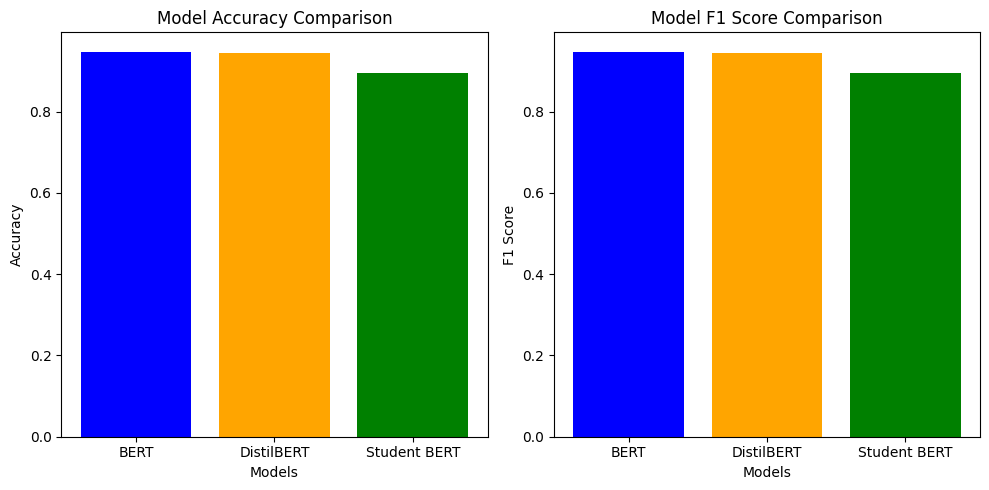

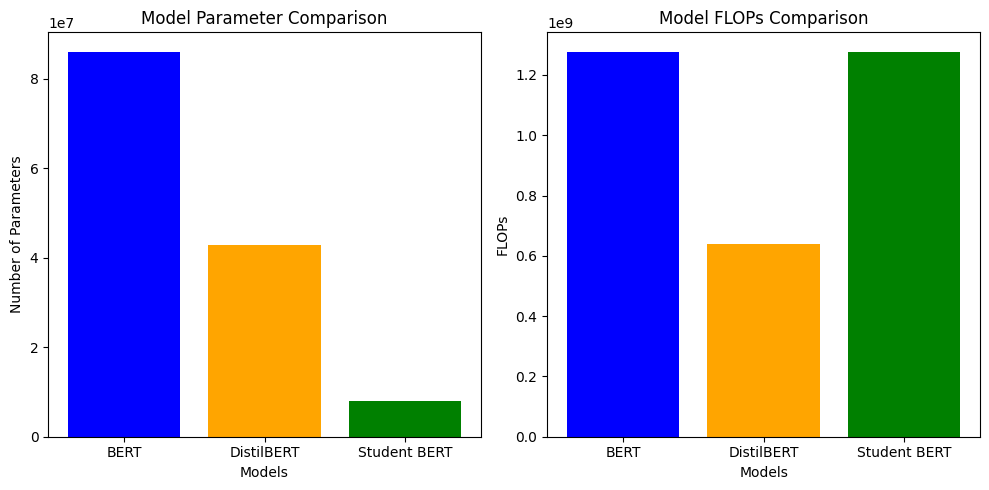

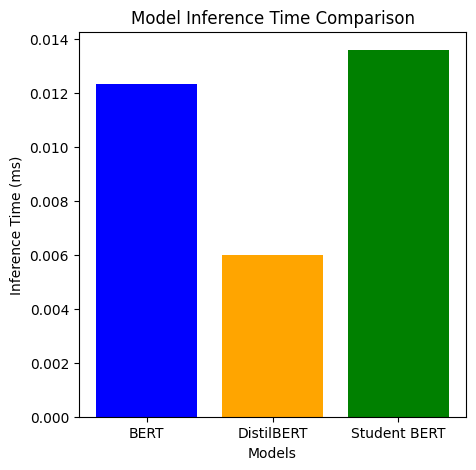

In [5]:
import os
import torch
import matplotlib.pyplot as plt
from transformers import BertTokenizer
from thop import profile
from hydra import compose, initialize
from hydra.core.global_hydra import GlobalHydra
from fakenews.model.model import BERTClass
from fakenews.model.distillation_model import StudentBERTClass, StudentDistilBERTClass
from fakenews.config import DISTILLED_MODEL, PROCESSED_DATA_DIR, BEST_MODEL
from fakenews.data.preprocessing import DataPreprocessor
from fakenews.inference.quantitization import measure_inference_time
from fakenews.inference.distillation import evaluate_model

%matplotlib inline

# Clear any existing Hydra instance
if GlobalHydra.instance().is_initialized():
    GlobalHydra.instance().clear()

# Initialize Hydra and load the configuration
initialize(config_path="../config", version_base="1.2")
cfg = compose(config_name="config")

# Load the preprocessed test data
preprocessor = DataPreprocessor(data_dir=PROCESSED_DATA_DIR, max_length=cfg.preprocess.max_length)
_, _, test_dataloader = preprocessor.process(
    batch_size=cfg.train.batch_size,
    test_size=cfg.train.test_size,
    val_size=cfg.train.val_size,
    random_state=cfg.train.random_state,
    processed_data_dir=PROCESSED_DATA_DIR,
)

# Determine the device (CPU, GPU, MPS)
# device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cpu")

# Load the BERT teacher model from local directory
bert_model = BERTClass(cfg)
checkpoint = torch.load(os.path.join(BEST_MODEL, "model.ckpt"), map_location=device)
bert_model.load_state_dict(checkpoint["state_dict"])

# Load the StudentDistilBERT model from local directory
dist_model = StudentDistilBERTClass(cfg)
checkpoint = torch.load(os.path.join(DISTILLED_MODEL, "stu_dist_bert_model.ckpt"), map_location=device)
dist_model.load_state_dict(checkpoint["state_dict"])

# Load the StudentBERT model from local directory
stu_model = StudentBERTClass(cfg)
checkpoint = torch.load(os.path.join(DISTILLED_MODEL, "stu_bert_model.ckpt"), map_location=device)
stu_model.load_state_dict(checkpoint["state_dict"])

# Evaluate each model
bert_metrics = evaluate_model(bert_model, test_dataloader, device)
dist_metrics = evaluate_model(dist_model, test_dataloader, device)
stu_metrics = evaluate_model(stu_model, test_dataloader, device)

# Measure inference time
tokenizer = BertTokenizer.from_pretrained(cfg.model.name)
dummy_input = tokenizer(
    "This is a dummy input", return_tensors="pt", max_length=15, padding="max_length", truncation=True
)
input_ids = dummy_input["input_ids"].to(device)
attention_mask = dummy_input["attention_mask"].to(device)

bert_inference_time = measure_inference_time(bert_model, input_ids, attention_mask, device)
dist_model_inference_time = measure_inference_time(dist_model, input_ids, attention_mask, device)
stu_bert_inference_time = measure_inference_time(stu_model, input_ids, attention_mask, device)

# Calculate FLOPs and parameters
bert_flops, bert_params = profile(bert_model, inputs=(input_ids, attention_mask))
dist_model_flops, dist_model_params = profile(dist_model, inputs=(input_ids, attention_mask))
stu_bert_flops, stu_bert_params = profile(stu_model, inputs=(input_ids, attention_mask))

# Plot comparison of performance on the test set
models = ["BERT", "DistilBERT", "Student BERT"]
accuracies = [bert_metrics["accuracy"], dist_metrics["accuracy"], stu_metrics["accuracy"]]
f1_scores = [bert_metrics["f1_score"], dist_metrics["f1_score"], stu_metrics["f1_score"]]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(models, accuracies, color=["blue", "orange", "green"])
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")

plt.subplot(1, 2, 2)
plt.bar(models, f1_scores, color=["blue", "orange", "green"])
plt.xlabel("Models")
plt.ylabel("F1 Score")
plt.title("Model F1 Score Comparison")

plt.tight_layout()
plt.show()

# Plot comparison of number of parameters and FLOPs
params = [bert_params, dist_model_params, stu_bert_params]
flops = [bert_flops, dist_model_flops, stu_bert_flops]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(models, params, color=["blue", "orange", "green"])
plt.xlabel("Models")
plt.ylabel("Number of Parameters")
plt.title("Model Parameter Comparison")

plt.subplot(1, 2, 2)
plt.bar(models, flops, color=["blue", "orange", "green"])
plt.xlabel("Models")
plt.ylabel("FLOPs")
plt.title("Model FLOPs Comparison")

plt.tight_layout()
plt.show()

# Plot comparison of average inference speed
inference_times = [bert_inference_time, dist_model_inference_time, stu_bert_inference_time]

plt.figure(figsize=(5, 5))
plt.bar(models, inference_times, color=["blue", "orange", "green"])
plt.xlabel("Models")
plt.ylabel("Inference Time (ms)")
plt.title("Model Inference Time Comparison")
plt.show()